In [1]:
%load_ext autoreload
%autoreload 2

**`схема семестра. что к чему.`**

# Как выбрать функцию близости

### План:
- классические функции близости на данных из датафрейма и их особенности 
    - bool
    - float
    - int
    - datetime
    - множества
    - string


- кастомные функции близости
    - categorical
    - обработка специальных значений


- композиция функций близости


- *функции близости на всем остальном


- *metric learning

## Классические функции близости

свойства метрики:
1) симметричность

2) $\rho(x, y) > 0$ при $x <> y$

3) $\rho(x, x) = 0$

4) неравенство треугольника:
    $\rho(x,z) <= \rho(x, y) + \rho(y, z)$
    
<br><br>
    
нам не нужны именно **метрики**, мы будем говорить о **функциях близости** (ФБ) со свойством симметричности на скалярах
    и векторах.
    

    
[Пост с хорошими картинками и описанием классических ФБ](https://www.maartengrootendorst.com/blog/distances/)
(оттуда натырил картинок)

<br>

### `bool`

**`True` vs `False`**

В первом приближении два була могут либо совпадать, либо не совпадать, поэтому расстояние между скалярами либо 1, либо 0.

Расстояние между векторами. `Hamming distance` - количество расхождений в векторах одинаковой длины

<img src='https://www.maartengrootendorst.com/assets/images/posts/2021-01-02-distances/hamming.png'>

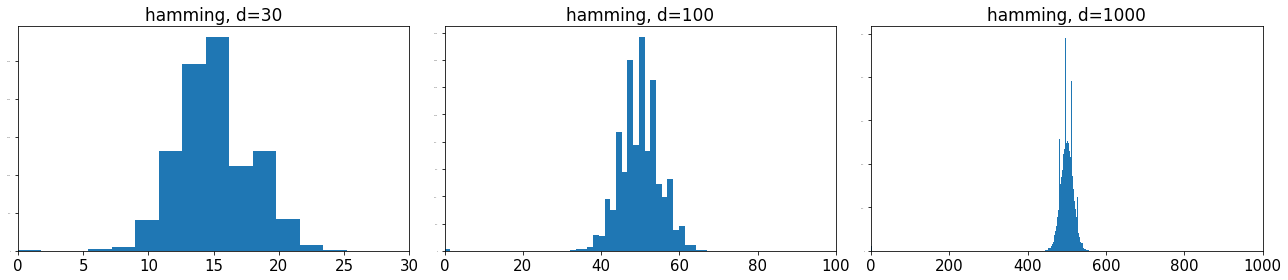

In [1]:
import numpy as np
from scipy.spatial.distance import cdist # считает попарные расстояния
import matplotlib.pyplot as plt


def make_random_data_return_distances_bool(n=1000, d=100):
    '''
    делает n случайных булевых вектора размерности d, считает попарные hamming distance и возвращает их
    
    returns: попарные hamming distances в виде np.array of shape (n,)
    '''
    X = np.random.randint(0, 2, size=(n, d))
    distances = cdist(X, X, 'hamming')
    return distances.ravel() * d

def plot_hist(data, bins=33, title=None, xlim=None, ax=None, **hist_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(title, fontsize=17)
    ax.hist(data, bins=bins, **hist_kwargs)
    ax.tick_params('x', labelsize=15)
    ax.tick_params('y', labelsize=0)
    ax.set_xlim(xlim)
    
fig, ax = plt.subplot_mosaic([[30, 100, 1000]], figsize=(18, 4))
for d in [30, 100, 1000]:
    distances = make_random_data_return_distances_bool(d=d)
    plot_hist(distances, bins=int(d/2), title=f'hamming, d={d}', xlim=(0, d), ax=ax[d])

fig.tight_layout()

это серия независимых испытаний Бернулли, поэтому распределение расстояний - биномиальное распределение с p=0.5

### continuous `float`

**`77.2` vs `36.13`**

два подхода:
- `интуитивный` - $\rho(vector, vector) = \phi(\sum \rho(scalar, scalar))$
    - euclidean
        - $\phi$ ~ $\sqrt x$
        - $\rho$ ~ $(x - y)^2$ 
    - manhattan
        - $\phi$ ~ $x$
        - $\rho$ ~ $|x - y|$
    - minkowski
        - $\phi$ ~ $x^{1/p}$
        - $\rho$ ~ $(x - y)^p$
    
    
- `альтернативный` - когда подходит по смыслу к задаче
    - cosine similarity - по углу между векторами
    - haversine - расстояние между точками на сфере по долготе и широте
    - коэффициенты корреляции

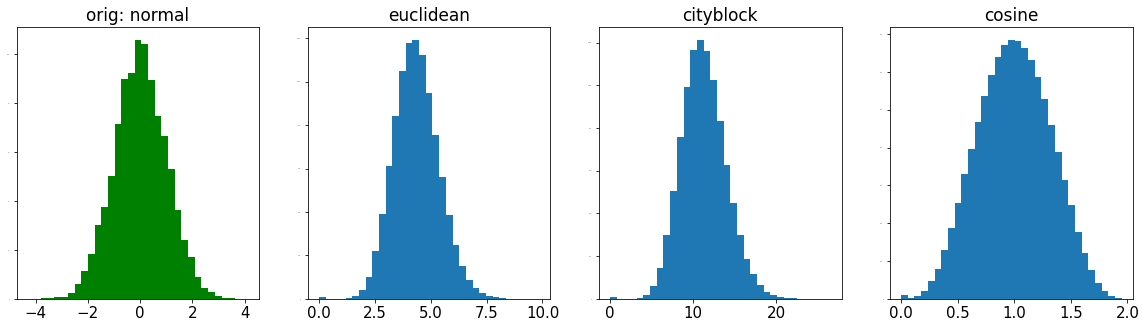

##############################################################################################################


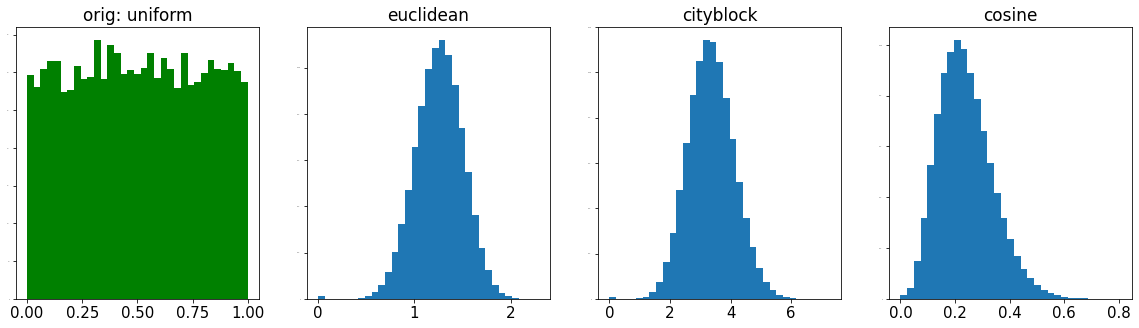

##############################################################################################################


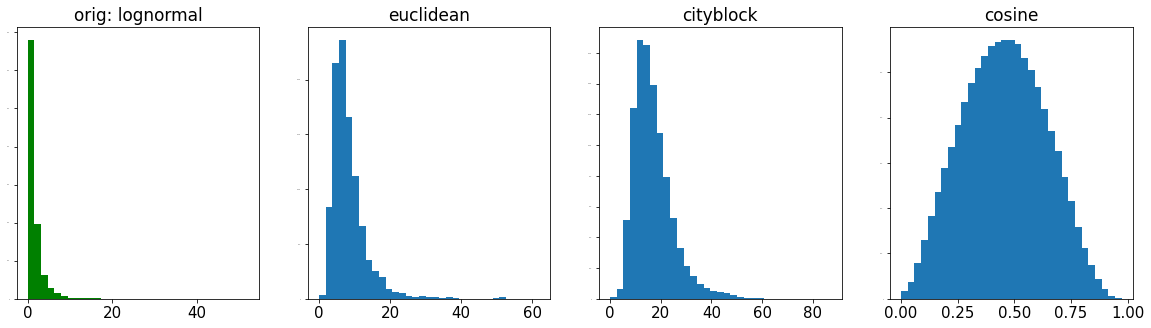

##############################################################################################################


In [21]:
def make_random_data_return_values_distances(n=1000, d=10, prob='normal', metric='euclidean', ravel=True, **metric_kwargs):
    '''
    prob in ['normal', 'uniform', 'lognormal']
    metric in `scipy.spatial.distances.cdist -> metric` format
    
    returns: original samples, distances
    '''
    if prob == 'uniform':
        X = np.random.uniform(size=(n, d))
    elif prob == 'normal':
        X = np.random.randn(n, d)
    elif prob == 'lognormal':
        X = np.random.lognormal(size=(n, d))
    else:
        raise NotImplementedError()
        
    distances = cdist(X, X, metric=metric, **metric_kwargs)
    
    if ravel:
        return X.ravel(), distances.ravel()
    return X, distances

d=10
for prob in ['normal', 'uniform', 'lognormal']:
    mosaic = [['orig', 'euclidean', 'cityblock', 'cosine']]
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(20, 5))
    for metric in ['euclidean', 'cityblock', 'cosine']:
        samples, distances = make_random_data_return_values_distances(d=d, prob=prob, metric=metric)
        if metric == 'euclidean': # только в первый раз
            plot_hist(samples, title=f'orig: {prob}', ax=ax['orig'], color='green')
        plot_hist(distances, bins=33, title=metric, ax=ax[metric])
    plt.show()
    print('#' * 110)

Посмотрим немного на проклятие размерности

100%|███████████████████████████████████████████████| 5/5 [00:59<00:00, 11.89s/it]


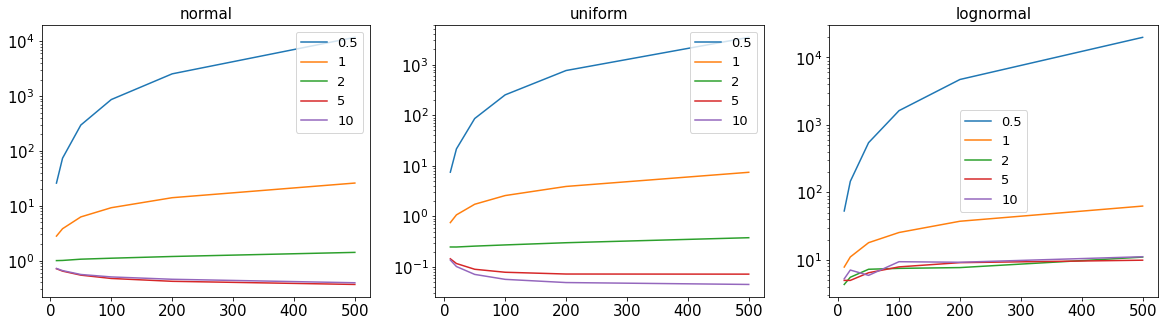

In [7]:
from tqdm import tqdm
import matplotlib as mpl

mpl.rcParams['legend.title_fontsize'] = 13
mpl.rcParams['legend.fontsize'] = 13


d_list = [10, 20, 50, 100, 200, 500]

mosaic = [['normal', 'uniform', 'lognormal']]
fig, ax = plt.subplot_mosaic(mosaic, figsize=(20, 5))
for prob in ['normal', 'uniform', 'lognormal']:
    for p in tqdm([0.5, 1, 2, 5, 10]):
        std_list = []
        for d in d_list:
            _, distances = make_random_data_return_values_distances(d=d, prob=prob, metric='minkowski', p=p)
            std_list.append(distances.std())
        
        ax[prob].plot(d_list, std_list, label=p)
    
    ax[prob].legend()
    ax[prob].set_yscale('log')
    ax[prob].tick_params('both', labelsize=15)
    ax[prob].set_title(prob, fontsize=15)

### continuous `int`

**`10` vs `117`**

справедливо все то же, что и для continuous float, но обычно - `Manhattan` или `Hamming`

<img src='https://www.maartengrootendorst.com/assets/images/posts/2021-01-02-distances/manhattan.png'>

**Зарисовка на тему того, совпадают ли соседи при использовании различных функций близости:**

In [88]:
n = 10_000
d = 10
samples, _ = make_random_data_return_values_distances(n=n, d=d, ravel=False)


from sklearn.neighbors import NearestNeighbors

nn_finder_euc = NearestNeighbors(n_neighbors=10, metric='euclidean')
nn_finder_euc.fit(samples)
euc_neighbors = nn_finder_euc.kneighbors()


from sklearn.neighbors import NearestNeighbors

nn_finder_manh = NearestNeighbors(n_neighbors=10, metric='manhattan')
nn_finder_manh.fit(samples)
manh_neighbors = nn_finder_manh.kneighbors()

print('доля совпадений:', (manh_neighbors[1] == euc_neighbors[1]).sum() / n / 10)

доля совпадений: 0.16011


### `datetime`

**`2023-03-10 16:00:00` vs `2022-10-16 14:58:20`**

считаем `datetime_x - datetime_y` в днях / часах / годах / секундах и т.п. и применяем предыдущие пункты про числа

### `множества`

**`{1, 2, 10, 15, 21}` vs `{1, 4, 3, 10, 120}`**

неупорядоченный набор элементов

классика | альтернатива 
- | -
<img src='https://www.maartengrootendorst.com/assets/images/posts/2021-01-02-distances/jaccard.png'> | <img src='https://www.maartengrootendorst.com/assets/images/posts/2021-01-02-distances/sorensen.png'>



In [93]:
# !pip install distance

In [94]:
import distance

distance.sorensen({1, 2, 10, 15, 21}, {1, 4, 3, 10, 120}), distance.jaccard({1, 2, 10, 15, 21}, {1, 4, 3, 10, 120})

(0.6, 0.75)

### `string`

**`'Иванов Иван'` vs `'Ивонофф Иван'`**

строка - упорядоченный набор символов.

<br>

Если порядок не важен, можно относиться и как к множествам

Если все строки одинаковой длины (к этому можно привести), можно использовать `Hamming distance`

<br>

Есть два классических способа посчитать близость между строками, да и вообще объектами "сложной природы":
- использовать функции близости на этих объектах
    - Levenshtein
    - Damerau-Levenshtein
    - Jaro-Winkler
    - Hamming (трактуем как векторы одинаковой длины)
    - Jaccard / Sorensen-Dice (трактуем как множества)


- получить эмбеддинги этих объектов (вектора-представления) и считать близости между эмбеддингами стандартными способами
    **(out of scope)**
    - bag of words
    - tf-idf
    - некоторые методы понижения размерности (зачастую для этого нужно предоставить функцию близости)
    - нейронные сети
    

**Две библиотеки:**

[**`rapidfuzz`**](https://github.com/maxbachmann/RapidFuzz) - классические расстояния и меры сходства быстро, мощно и удобно
- `rapidfuzz.distance` - классика


- `rapidfuzz.fuzz` - еще всякие меры сходства, возвращают float in [0, 100]


- `rapidfuzz.process` - модуль для организации "процессов", связанных со строками
    - `rapidfuzz.process.cdist` - быстрый аналог scipy
    
    
- `rapidfuzz.utils` - стандартный препроцессор строк
    
<br>
    
[**`jellyfish`**](https://github.com/jamesturk/jellyfish) - фонетические кодировки

In [100]:
# !pip install jellyfish rapidfuzz

Создадим данные для экспериментов со строками

In [109]:
X = np.random.randint(low=1e8, high=1e9 - 1, size=(1000, 1)).astype(str) # строки длины 9
X[:3]

array([['122722608'],
       ['115531925'],
       ['258701811']], dtype='<U11')

Сравнение скоростей работы и cdist:

In [121]:
import jellyfish

%timeit -o cdist(X, X, metric=lambda x, y: jellyfish.levenshtein_distance(x[0], y[0]))

import rapidfuzz

%timeit -o cdist(X, X, metric=lambda x, y: rapidfuzz.distance.Levenshtein.distance(x[0], y[0]))

%timeit -o rapidfuzz.process.cdist(X.reshape(-1), X.reshape(-1), scorer=rapidfuzz.distance.Levenshtein.distance)

_ = ''

3.35 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.12 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
20.8 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Фонетические кодировки jellyfish и их применение

In [143]:
print('"Ann" encoding:', jellyfish.match_rating_codex('Ann'))
print('"Anne" encoding:', jellyfish.match_rating_codex('Anne'))

# их можно подавать в качестве processor в rapidfuzz
rapidfuzz.process.cdist(
    X.reshape(-1), X.reshape(-1), scorer=rapidfuzz.distance.Levenshtein.distance,
    processor=jellyfish.match_rating_codex
)

# также, в rapidfuzz есть встроенный processor
rapidfuzz.process.cdist(
    X.reshape(-1), X.reshape(-1), scorer=rapidfuzz.distance.Levenshtein.distance,
    processor=rapidfuzz.utils.default_process
)

# также, можно подключать сюда питоновский модуль с регулярными выражениями - re

"Ann" encoding: AN
"Anne" encoding: AN


array([[0, 8, 8, ..., 9, 9, 7],
       [8, 0, 8, ..., 8, 7, 9],
       [8, 8, 0, ..., 7, 9, 9],
       ...,
       [9, 8, 7, ..., 0, 7, 8],
       [9, 7, 9, ..., 7, 0, 8],
       [7, 9, 9, ..., 8, 8, 0]], dtype=int32)

## Кастомные функции близости

подводка на примере bool:

**`True` vs `True`** и **`False` vs `False`** не обязательно находятся на одинаковом расстоянии 

<br>

### `categorical`

**`'medium'` vs `'high'`**

придется мастерить самим - зависит от смысла

In [3]:
import pandas as pd

dummy = pd.Series(np.random.choice(['low', 'medium', 'high'], size=1000, p=[0.1, 0.4, 0.5]))
dummy.value_counts()

high      500
medium    401
low        99
Name: count, dtype: int64

In [ ]:
# пример

distances = {
        'low': {
            'low': 0,
            'medium': 2,
            'high': np.inf
        }
        'medium': {
            'low': 2,
            'medium': 0,
            'high': 5
        }
        'high': {
            'low': np.inf,
            'medium': 5,
            'high': 1 # не обязательно 0 :)
        }
    }

def category_col_distance(cat_1, cat_2, distance_dict):
    return distance_dict[cat_1][cat_2]


# еще пример
dummy = dummy.map({'low': 0, 'medium': 2, 'high': 5}) # а дальше воспринимать эту колонку как интовую

### `обработка специальных значений`

не забывайте о том, чтобы обрабатывать наны, нули, пустые строки и любые другие спец. значения

In [148]:
# пример обработки нанов

def nan_euclidean(vec1, vec2):
    vec1_na_cond = pd.isna(vec1)
    vec2_na_cond = pd.isna(vec2)
    
    squared_diff = (vec1 - vec2) ** 2
    squared_diff[vec1_na_cond] = vec2[vec1_na_cond] # left nan
    squared_diff[vec2_na_cond] = vec1[vec2_na_cond] # right nan
    squared_diff[vec1_na_cond & vec2_na_cond] = 0 # both nan
    
    return np.sqrt(squared_diff.sum())

vec1 = np.array([1, 2, 3, np.nan])
vec2 = np.array([1, 2, np.nan, np.nan])

nan_euclidean(vec1, vec2) # корень из трех

1.7320508075688772

## Композиция функций близости

**Оставляю этот блок в том виде, в котором он оказался на семинаре. Возможно, у меня дойдут руки его допилить...**

постараемся подобрать "универсальную меру близости" для пассажиров титаника, и с помощью нее решить задачу методом kNN в прямом эфире

In [12]:
import pandas as pd

tr = pd.read_csv('titanic/train.csv')
tst = pd.read_csv('titanic/test.csv')
tr.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


какие [колонки](https://www.kaggle.com/competitions/titanic/data) возьмем в нашу метрику?

`PassengerId`, `Embarked`, `Ticket`

берем: `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `*Name`


как их отобрать в общем случае?

In [20]:
tr.Fare.value_counts(normalize=True, dropna=False)
# plt.hist(tr.Age, bins=33)
# _ = ''

Fare
8.0500     0.048260
13.0000    0.047138
7.8958     0.042649
7.7500     0.038159
26.0000    0.034792
             ...   
35.0000    0.001122
28.5000    0.001122
6.2375     0.001122
14.0000    0.001122
10.5167    0.001122
Name: proportion, Length: 248, dtype: float64

In [ ]:
distance_dict = {
    1: {
        1: 0,
        2: 2,
        3: 10
    },
    2: {
        1: 2,
        2: 0,
        3: 4
    },
    3: {
        1: 10,
        2: 4,
        3: 0
    }
}

def pclass_dist(pclass1, pclass2, distance_dict):
    return distance_dict[pclass1][pclass2]

def sex_dist(sex1, sex2):
    return int(sex1 != sex2)

def manh_dist(x1, x2):
    return np.abs(x1 - x2)

def euc_dist(x1, x2):
    return (x1 - x2) ** 2

x_test -> k neighbors from X_train -> mode(kneighbors.Survived)

для каждого x_test, x_train, нужно посчитать
phi(pclass_dist, sex_dist, manh_dist_age, ..., euc_dist_fare)

In [ ]:
def main_similarity(vec1, vec2, pclass_weight, sex_weight, age_weight): # vec - [pclass, sex, fare, ...]
    pclass_dist_score = pclass_dist(vec1['Pclass'], vec2['Pclass'])
    sex_dist_score = sex_dist(vec1['Sex'], vec2['Sex'])
    age_dist_score = manh_dist(vec1['Age'], vec2['Age'])
    
    # поправить распределения
    
    return pclass_weight * pclass_dist_score + sex_dist_score * sex_weight + ...

In [ ]:
import optuna
from functools import partial

def objective(trial, ...):
    pclass_weight = trial.suggest_float(...)
    ...
    k = trial.suggest_float(...)
    
    my_metric = partial(main_similarity, fix: pclass_weight, sex_weight, age_weight)
    model = KNN(kneighbors=k, metric=my_metric)
    model.fit(X_tr)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_tst, y_pred)
    return score

In [ ]:
study = ...
study.optimize(n_trials=300)

## *Дополнительный раздел

есть еще куча объектов, о близостях между которыми мы не говорили на семинаре - есть куда копать и что изучать!
- матрицы и тензоры (напр. картинки)
- графы
- аудио
- последовательности, перестановки
- временные ряды
- распределения вероятностей
- ...

### [`metric-learn`](https://github.com/scikit-learn-contrib/metric-learn) - библиотека обучения метрик